In [138]:
from glob import glob
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
import re

import sys
home=os.path.expanduser("~")
sys.path.append(os.path.join(home, 'station2grid'))

from tools import plotMap, CommonObj
%matplotlib inline

from scipy.stats import entropy


In [139]:
info = CommonObj().epa_station_info
info.head()

,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125
1,牧山,Mushan,mountain,23.864722,121.152222,23.86,121.15,148,115
2,玉山,Yushan,mountain,23.470556,120.948889,23.47,120.95,187,95
3,北大武山,Beidawushan,mountain,22.629167,120.751944,22.63,120.75,271,75
4,陽明,Yangming,city,25.182722,121.529583,25.18,121.53,16,153


In [140]:
epa_features = pd.read_csv('/media/disk3/feynman52/station2grid/datasets/info/epa-features')
air_features = pd.read_csv('/media/disk3/feynman52/station2grid/datasets/info/air-features')
sat_features = pd.read_csv('/media/disk3/feynman52/station2grid/datasets/info/sat-features')

len(epa_features), len(air_features), len(sat_features), 

(19, 22, 22)

# fix station, pm2.5, (air,sat,epa) distribution

In [141]:
path = '/media/disk3/feynman52/station2grid/datasets/npy/air/domain_air-k_3-weightKNN_distance/station'
station_paths = sorted(glob(os.path.join(path,'*_station_addmou_addfea.npy')))  
air_stations = np.concatenate([np.load(x) for x in station_paths[:]], axis=0)
air_stations.shape


(30005, 77, 22)

In [142]:
path = '/media/disk3/feynman52/station2grid/datasets/npy/sat/domain_sat-k_3-weightKNN_distance/station'
station_paths = sorted(glob(os.path.join(path,'*_station_addmou_addfea.npy')))  
sat_stations = np.concatenate([np.load(x) for x in station_paths[:]], axis=0)


sat_stations.shape

(4383, 77, 22)

In [143]:
path='/media/disk3/feynman52/station2grid/datasets/npy/epa/train_epa_addmou.npy'
epa_stations = np.load(path)
epa_stations.shape


(43824, 77, 19)

In [144]:
path='/media/disk3/feynman52/station2grid/datasets/npy/epa/test_epa_addmou.npy'
test_epa_stations = np.load(path)


test_epa_stations.shape

(8760, 77, 19)

In [145]:
feature = 'PM25'
i_fea_epa = epa_features.feature.tolist().index('PM25')
i_fea_air = air_features.feature.tolist().index('pm25')
i_fea_sat = sat_features.feature.tolist().index('pm25')

i_fea_epa, i_fea_air, i_fea_sat,

(0, 0, 0)

In [146]:
station = 'Changhua'
i_sta = info.SiteEngName.tolist().index(station)
i_sta

43

In [147]:
# 2017~2018
epa_station = epa_stations[365*24*3:, i_sta, i_fea_epa]
air_station = air_stations[:, i_sta, i_fea_air]
sat_station = sat_stations[365*3*2:, i_sta, i_fea_sat]

epa_station.shape, air_station.shape, sat_station.shape

((17544,), (30005,), (2193,))

Text(0.5,1,'Changhua')

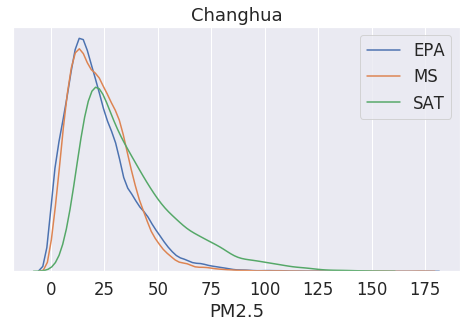

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(16/2, 9/2)
sns.set(font_scale=1.5)
for data, label in [[epa_station,'EPA'],[air_station,'MS'],[sat_station,'SAT']]:
    sns.distplot(
        data, 
        bins=5, 
        hist=False, 
        kde=True, 
        label=label, 
        ax=ax
    )
ax.set_yticks([])
ax.set_xlabel('PM2.5')
ax.set_title(station)

In [149]:
def get_prob_dist(arr, arr_range=(0,150), bins=10):
    count, division = np.histogram(
        arr,
        bins=bins,
        range=arr_range,
    )    
    prob_dist = count/sum(count)
    return prob_dist


In [150]:
epa_prob_dist = get_prob_dist(epa_station, arr_range=(0,150), bins=10)
air_prob_dist = get_prob_dist(air_station, arr_range=(0,150), bins=10)
sat_prob_dist = get_prob_dist(sat_station, arr_range=(0,150), bins=10)

kld_epa_air = entropy(pk=epa_prob_dist, qk=air_prob_dist)
kld_epa_sat = entropy(pk=epa_prob_dist, qk=sat_prob_dist)

round(kld_epa_air,2), round(kld_epa_sat,2)

(0.01, 0.32)

In [151]:
# for i_sta in range(4,77):
#     epa_station = epa_stations[365*24*3:, i_sta, i_fea_epa]
#     air_station = air_stations[:, i_sta, i_fea_air]
#     sat_station = sat_stations[365*3*2:, i_sta, i_fea_sat]
#     fig, ax = plt.subplots()
#     sns.set(font_scale=1.5)
#     for data, label in [[epa_station,'EPA'],[air_station,'MS'],[sat_station,'SAT']]:
#         sns.distplot(
#             data, 
#             bins=5, 
#             hist=False, 
#             kde=True, 
#             label=label, 
#             ax=ax
#         )    
#     plt.title('%s'%(i_sta))
#     plt.show()

# (train_sat_pm25_minmax, test_epa_pm25_minmax), (train_sat_pm25_standard, test_epa_pm25_standard), 

In [156]:
path = '/media/disk3/feynman52/station2grid/datasets/npy/sat/domain_sat-k_3-weightKNN_distance/station'
station_paths = sorted(glob(os.path.join(path,'*_station_addmou_addfea_minmax_norm.npy')))  
train_sat_minmax = np.concatenate([np.load(x) for x in station_paths[:]], axis=0)

path = '/media/disk3/feynman52/station2grid/datasets/npy/sat/domain_sat-k_3-weightKNN_distance/station'
station_paths = sorted(glob(os.path.join(path,'*_station_addmou_addfea_standard_norm.npy')))  
train_sat_standard = np.concatenate([np.load(x) for x in station_paths[:]], axis=0)


train_sat_minmax.shape, train_sat_standard.shape

((4383, 77, 22), (4383, 77, 22))

In [157]:
path='/media/disk3/feynman52/station2grid/datasets/npy/epa/test_epa_addmou_minmax_norm.npy'
test_epa_minmax = np.load(path)

path='/media/disk3/feynman52/station2grid/datasets/npy/epa/test_epa_addmou_standard_norm.npy'
test_epa_standard = np.load(path)

test_epa_minmax.shape, test_epa_standard.shape

((8760, 77, 19), (8760, 77, 19))

In [154]:
i_fea_epa = epa_features.feature.tolist().index('PM25')
i_fea_air = air_features.feature.tolist().index('pm25')
i_fea_sat = sat_features.feature.tolist().index('pm25')

print(i_fea_epa, i_fea_air, i_fea_sat,)

station = 'Changhua'
i_sta = info.SiteEngName.tolist().index(station)
print(i_sta)


0 0 0
43


In [155]:
train_sat_minmax_sta_pm25 = train_sat_minmax[:, i_sta, i_fea_sat]
test_epa_minmax_sta_pm25 = test_epa_minmax[:, i_sta, i_fea_epa]

train_sat_minmax_sta_pm25.shape, test_epa_minmax_sta_pm25.shape

((4383,), (8760,))

In [158]:
train_sat_standard_sta_pm25 = train_sat_standard[:, i_sta, i_fea_sat]
test_epa_standard_sta_pm25 = test_epa_standard[:, i_sta, i_fea_epa]

train_sat_standard_sta_pm25.shape, test_epa_standard_sta_pm25.shape

((4383,), (8760,))

Text(0.5,1,'Changhua')

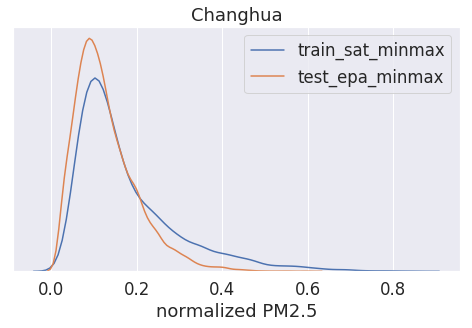

In [159]:
fig, ax = plt.subplots()
fig.set_size_inches(16/2, 9/2)
sns.set(font_scale=1.5)
for data, label in [[train_sat_minmax_sta_pm25,'train_sat_minmax'],[test_epa_minmax_sta_pm25,'test_epa_minmax']]:
    sns.distplot(
        data, 
        bins=5, 
        hist=False, 
        kde=True, 
        label=label, 
        ax=ax
    )
    
ax.set_yticks([])
ax.set_xlabel('normalized PM2.5')
ax.set_title(station)

In [170]:
epa_prob_dist = get_prob_dist(test_epa_minmax_sta_pm25, arr_range=(0,1), bins=10)
sat_prob_dist = get_prob_dist(train_sat_minmax_sta_pm25, arr_range=(0,1), bins=10)

kld_epa_sat = entropy(pk=epa_prob_dist, qk=sat_prob_dist)

round(kld_epa_sat,2)

0.09

Text(0.5,1,'Changhua')

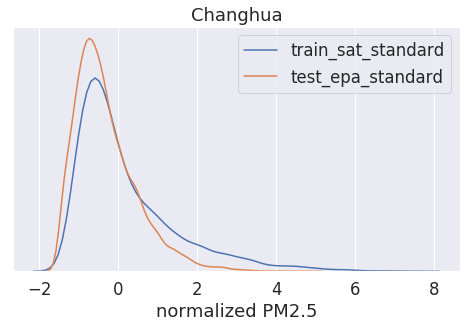

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(16/2, 9/2)
sns.set(font_scale=1.5)
for data, label in [[train_sat_standard_sta_pm25,'train_sat_standard'],[test_epa_standard_sta_pm25,'test_epa_standard']]:
    sns.distplot(
        data, 
        bins=5, 
        hist=False, 
        kde=True, 
        label=label, 
        ax=ax
    )
    
ax.set_yticks([])
ax.set_xlabel('normalized PM2.5')
ax.set_title(station)

In [169]:
epa_prob_dist = get_prob_dist(test_epa_standard_sta_pm25, arr_range=(-2,8), bins=10)
sat_prob_dist = get_prob_dist(train_sat_standard_sta_pm25, arr_range=(-2,8), bins=10)

kld_epa_sat = entropy(pk=epa_prob_dist, qk=sat_prob_dist)

round(kld_epa_sat,2)

0.12

# (train_sat_pm10 vs test_epa_pm10), (train_epa_pm10 vs test_epa_pm10)

In [171]:
path = '/media/disk3/feynman52/station2grid/datasets/npy/sat/domain_sat-k_3-weightKNN_distance/station'
station_paths = sorted(glob(os.path.join(path,'*_station_addmou_addfea.npy')))  
train_sat = np.concatenate([np.load(x) for x in station_paths[:]], axis=0)

train_sat.shape

(4383, 77, 22)

In [172]:
path='/media/disk3/feynman52/station2grid/datasets/npy/epa/test_epa_addmou.npy'
test_epa = np.load(path)

path='/media/disk3/feynman52/station2grid/datasets/npy/epa/train_epa_addmou.npy'
train_epa = np.load(path)

test_epa.shape, train_epa.shape

((8760, 77, 19), (43824, 77, 19))

In [323]:
i_fea_epa = epa_features.feature.tolist().index('PM10')
i_fea_sat = sat_features.feature.tolist().index('pm10')

print(i_fea_epa, i_fea_sat,)

station = 'Keelung'
i_sta = info.SiteEngName.tolist().index(station)
print(i_sta)


1 1
7


In [324]:
train_sat_sta_pm10 = train_sat[:, i_sta, i_fea_sat]

train_sat_sta_pm10.shape

(4383,)

In [325]:
# 2017~2018
train_epa_sta_pm10 = train_epa[365*24*3:, i_sta, i_fea_epa]

train_epa_sta_pm10.shape

(17544,)

In [326]:
test_epa_sta_pm10 = test_epa[:, i_sta, i_fea_epa]

test_epa_sta_pm10.shape

(8760,)

(-10, 300)

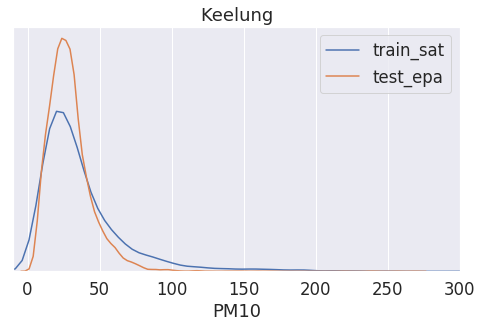

In [327]:
fig, ax = plt.subplots()
fig.set_size_inches(16/2, 9/2)
sns.set(font_scale=1.5)
for data, label in [[train_sat_sta_pm10,'train_sat'],[test_epa_sta_pm10,'test_epa']]:
    sns.distplot(
        data, 
        bins=5, 
        hist=False, 
        kde=True, 
        label=label, 
        ax=ax
    )
    
ax.set_yticks([])
ax.set_xlabel('PM10')
ax.set_title(station)
ax.set_xlim(-10, 300)

In [328]:
p = get_prob_dist(train_sat_sta_pm10, arr_range=(0,100), bins=10)
q = get_prob_dist(test_epa_sta_pm10, arr_range=(0,100), bins=10)

kld = entropy(pk=p, qk=q)

round(kld,2)

0.09

(-10, 300)

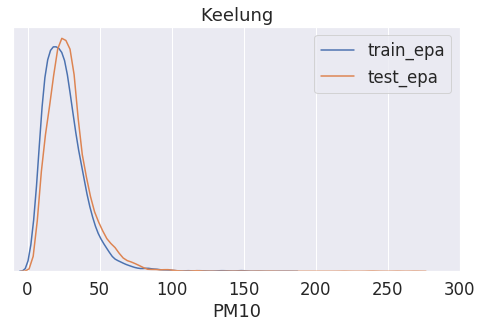

In [329]:
fig, ax = plt.subplots()
fig.set_size_inches(16/2, 9/2)
sns.set(font_scale=1.5)
for data, label in [[train_epa_sta_pm10,'train_epa'],[test_epa_sta_pm10,'test_epa']]:
    sns.distplot(
        data, 
        bins=5, 
        hist=False, 
        kde=True, 
        label=label, 
        ax=ax
    )
    
ax.set_yticks([])
ax.set_xlabel('PM10')
ax.set_title(station)
ax.set_xlim(-10, 300)

In [330]:
p = get_prob_dist(train_epa_sta_pm10, arr_range=(0,100), bins=10)
q = get_prob_dist(test_epa_sta_pm10, arr_range=(0,100), bins=10)

kld = entropy(pk=p, qk=q)

round(kld,2)

0.05